In [1]:
# import your standard packages
%run ../../global-tools/start.py

# import your local functions
sys.path.insert(1, '../local-tools/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Seasonal Ekman Pumping

To isolate interior ekman pumping, this code follows https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2011JC007531

Need to still do alongshore wind stress at some point too...need local bathymetry for that...perhaps cartopy has it.

https://earthweb.ess.washington.edu/roe/Web_page_514/ESS514/Notes_files/MarshallPlumb_GulfStream.pdf

https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdQMstress1day.html

Still need to add in beta affect perhaps! See SI of chl 2016 paper

In [2]:
ds_wnd = xr.open_dataset('../data/NCEP_Wind/ncep_wind_processed.nc')

# Get data, selecting lat/lon slice
uwnd = ds_wnd['uwnd']
vwnd = ds_wnd['vwnd']
lat = uwnd.lat.values
lon = uwnd.lon.values
t = uwnd.time

In [3]:
# wind stress

# air density
p_air = 1.225 # kg/m^3
p_sea = 1025 # kg/m^3

xx,yy = np.meshgrid(lon,lat)

f = coriolis_par(yy)

n = len(ds_wnd.time)
m = len(ds_wnd.lat)
p = len(ds_wnd.lon)

Wnd_sp = np.full(uwnd.shape,np.nan)
curl_tau = np.full(uwnd.shape,np.nan)
W_Ek = np.full(uwnd.shape,np.nan)
tau_x = np.full(uwnd.shape,np.nan)
tau_y = np.full(uwnd.shape,np.nan)

for tt in tqdm(range(len(t))):
    tmpu = uwnd[tt,:,:]
    tmpv = vwnd[tt,:,:]

    # define wind speed
    W = np.array(np.sqrt(np.power(tmpu,2) + np.power(tmpv,2)))
    Wnd_sp[tt,:,:] = W

    # define drag coeficient matrix 
    C_d = np.full(xx.shape,np.nan)
    C_d[W < 11] = 0.0012
    C_d[W >= 11] = 0.00049 + W[W >= 11]*0.000065

    # calculate wind stress
    tau_x[tt,:,:] = p_air * C_d * W * tmpu
    tau_y[tt,:,:] = p_air * C_d * W * tmpv

    # find wind stress curl
    curl_tau[tt,:,:],_,_ = latlon_2D_vorticity(tau_x[tt,:,:],tau_y[tt,:,:],yy,xx)
    W_Ek[tt,:,:] = curl_tau[tt,:,:]/(p_sea * f)


100%|██████████| 497/497 [02:25<00:00,  3.38it/s]


In [4]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': lon,
                    'lat': lat,
                    'time': t})

# add variables to dataset
ds["uwnd"]=xr.DataArray(uwnd,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])
ds["vwnd"]=xr.DataArray(vwnd,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])
ds["Wnd_sp"]=xr.DataArray(Wnd_sp,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])
ds["curl_tau"]=xr.DataArray(curl_tau,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])
ds["tau_x"]=xr.DataArray(tau_x,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])
ds["tau_y"]=xr.DataArray(tau_y,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])
ds["W_Ek"]=xr.DataArray(W_Ek,dims = ['time','lat','lon'],
                     coords =[t,lat,lon])

In [9]:
# find climatologies/anomalies
uwnd_seas_clim = seasonal_clim(ds.uwnd)
uwnd_mon_clim = monthly_clim(ds.uwnd)

vwnd_seas_clim = seasonal_clim(ds.vwnd)
vwnd_mon_clim = monthly_clim(ds.vwnd)

Wnd_sp_seas_clim = seasonal_clim(ds.Wnd_sp)
Wnd_sp_mon_clim = monthly_clim(ds.Wnd_sp)

curl_tau_seas_clim = seasonal_clim(ds.curl_tau)
curl_tau_mon_clim = monthly_clim(ds.curl_tau)

tau_x_seas_clim = seasonal_clim(ds.tau_x)
tau_x_mon_clim = monthly_clim(ds.tau_x)

tau_y_seas_clim = seasonal_clim(ds.tau_y)
tau_y_mon_clim = monthly_clim(ds.tau_y)

W_Ek_seas_clim = seasonal_clim(ds.W_Ek)
W_Ek_mon_clim = monthly_clim(ds.W_Ek)

# add to dataset
ds["uwnd_seas_clim"]=xr.DataArray(uwnd_seas_clim,dims = ['season','lat','lon'],
                     coords =[uwnd_seas_clim.season,lat,lon])
ds["uwnd_mon_clim"]=xr.DataArray(uwnd_mon_clim,dims = ['month','lat','lon'],
                     coords =[uwnd_mon_clim.month,lat,lon])

ds["vwnd_seas_clim"]=xr.DataArray(vwnd_seas_clim,dims = ['season','lat','lon'],
                     coords =[vwnd_seas_clim.season,lat,lon])
ds["vwnd_mon_clim"]=xr.DataArray(vwnd_mon_clim,dims = ['month','lat','lon'],
                     coords =[vwnd_mon_clim.month,lat,lon])

ds["Wnd_sp_seas_clim"]=xr.DataArray(Wnd_sp_seas_clim,dims = ['season','lat','lon'],
                     coords =[Wnd_sp_seas_clim.season,lat,lon])
ds["Wnd_sp_mon_clim"]=xr.DataArray(Wnd_sp_mon_clim,dims = ['month','lat','lon'],
                     coords =[Wnd_sp_mon_clim.month,lat,lon])

ds["curl_tau_seas_clim"]=xr.DataArray(curl_tau_seas_clim,dims = ['season','lat','lon'],
                     coords =[curl_tau_seas_clim.season,lat,lon])
ds["curl_tau_mon_clim"]=xr.DataArray(curl_tau_mon_clim,dims = ['month','lat','lon'],
                     coords =[curl_tau_mon_clim.month,lat,lon])

ds["tau_x_seas_clim"]=xr.DataArray(tau_x_seas_clim,dims = ['season','lat','lon'],
                     coords =[tau_x_seas_clim.season,lat,lon])
ds["tau_x_mon_clim"]=xr.DataArray(tau_x_mon_clim,dims = ['month','lat','lon'],
                     coords =[tau_x_mon_clim.month,lat,lon])

ds["tau_y_seas_clim"]=xr.DataArray(tau_y_seas_clim,dims = ['season','lat','lon'],
                     coords =[tau_y_seas_clim.season,lat,lon])
ds["tau_y_mon_clim"]=xr.DataArray(tau_y_mon_clim,dims = ['month','lat','lon'],
                     coords =[tau_y_mon_clim.month,lat,lon])

ds["W_Ek_seas_clim"]=xr.DataArray(W_Ek_seas_clim,dims = ['season','lat','lon'],
                     coords =[W_Ek_seas_clim.season,lat,lon])
ds["W_Ek_mon_clim"]=xr.DataArray(W_Ek_mon_clim,dims = ['month','lat','lon'],
                     coords =[W_Ek_mon_clim.month,lat,lon])

In [22]:
ds

<xarray.Dataset>
Dimensions:             (lat: 27, lon: 46, month: 12, season: 4, time: 497)
Coordinates:
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
  * lon                 (lon) float32 35.625 37.5 39.375 ... 118.125 120.0
  * lat                 (lat) float32 -19.9997 -18.095 ... 27.6186 29.5234
  * time                (time) datetime64[ns] 1979-01-01 ... 2020-05-01
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    uwnd                (time, lat, lon) float32 -3.399994 ... -1.5340325
    vwnd                (time, lat, lon) float32 2.1799927 ... 1.3312091
    Wnd_sp              (time, lat, lon) float64 4.039 4.134 ... 1.381 2.031
    curl_tau            (time, lat, lon) float64 -4.489e-08 ... 1.903e-08
    tau_x               (time, lat, lon) float64 -0.02019 -0.01939 ... -0.00458
    tau_y               (time, lat, lon) float64 0.01294 0.01598 ... 0.003975
    W_Ek                (time, lat, lon) float64 8.783e-07 ... 2.585e-0

Text(0.5, 1.0, 'SON')

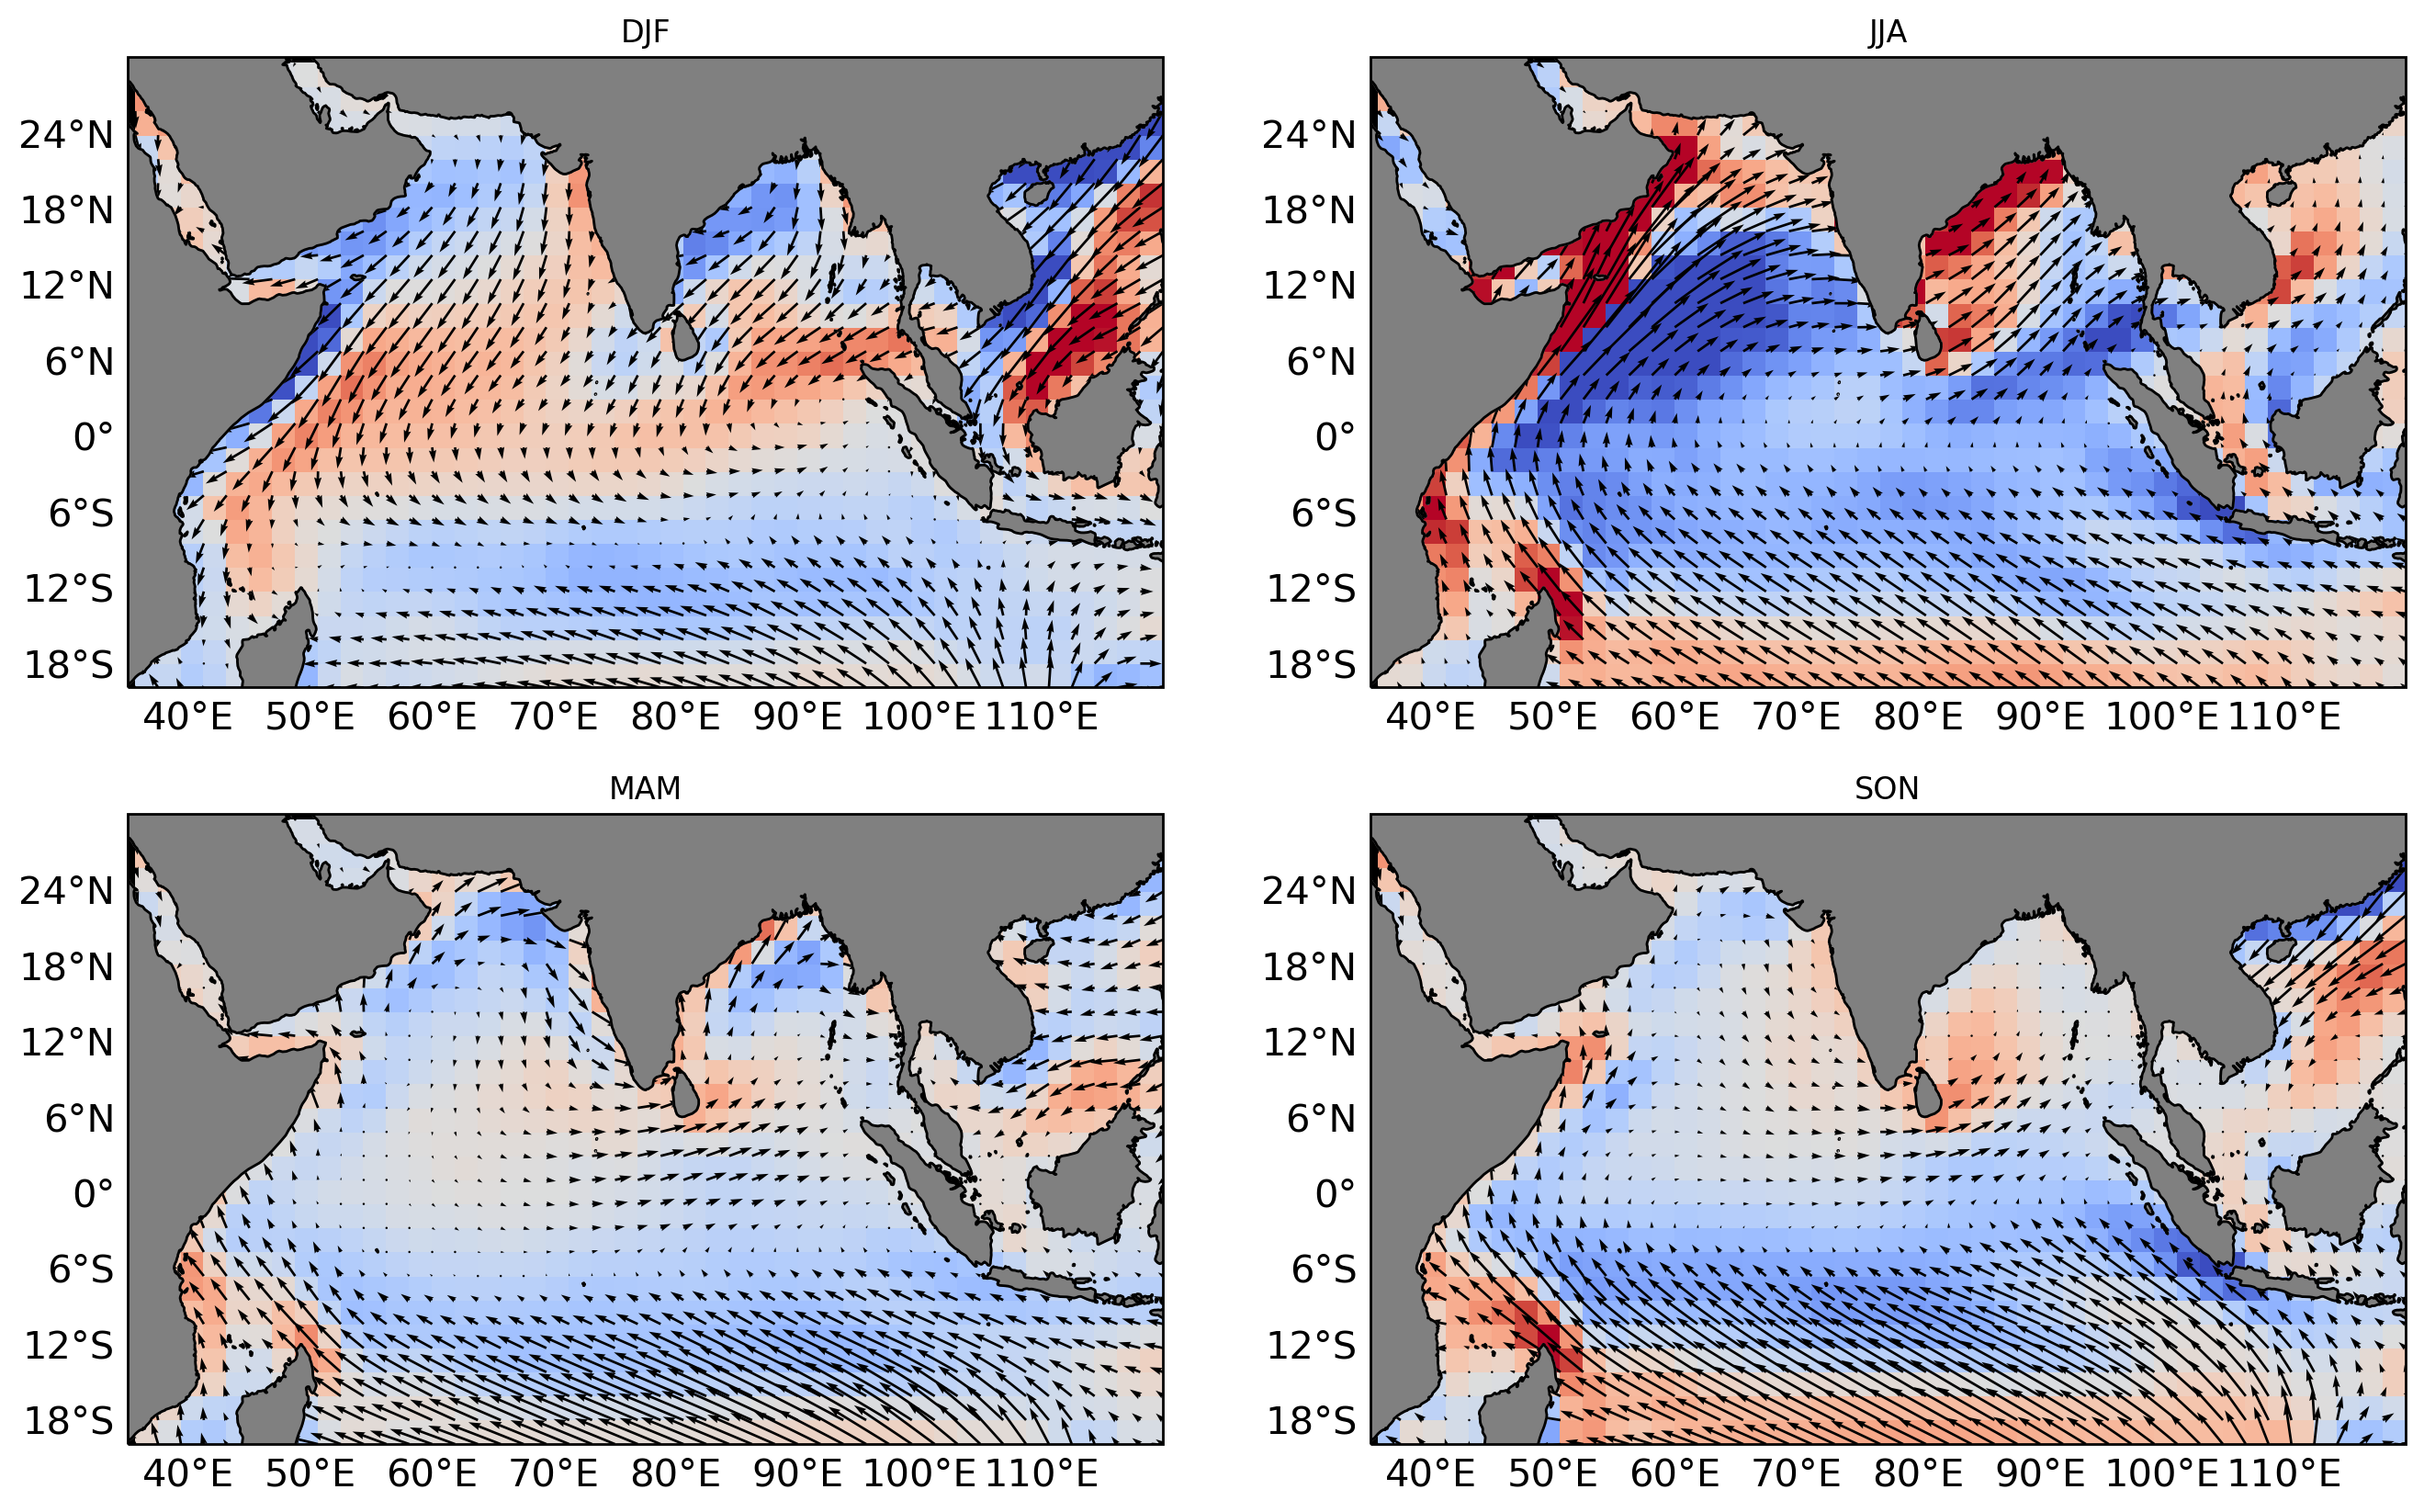

In [17]:
cmin = -2e-7
cmax = 2e-7
fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})

ax = axes[0,0]
p = ax.pcolor(xx,yy,ds.curl_tau_seas_clim[0,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.uwnd_seas_clim[0,:,:],ds.vwnd_seas_clim[0,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[0]))

ax = axes[0,1]
p = ax.pcolor(xx,yy,curl_tau_seas_clim[1,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[1,:,:],tau_y_seas_clim[1,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[1]))

ax = axes[1,0]
p = ax.pcolor(xx,yy,curl_tau_seas_clim[2,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[2,:,:],tau_y_seas_clim[2,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[2]))

ax = axes[1,1]
p = ax.pcolor(xx,yy,curl_tau_seas_clim[3,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[3,:,:],tau_y_seas_clim[3,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[3]))



Text(0.5, 1.0, 'SON')

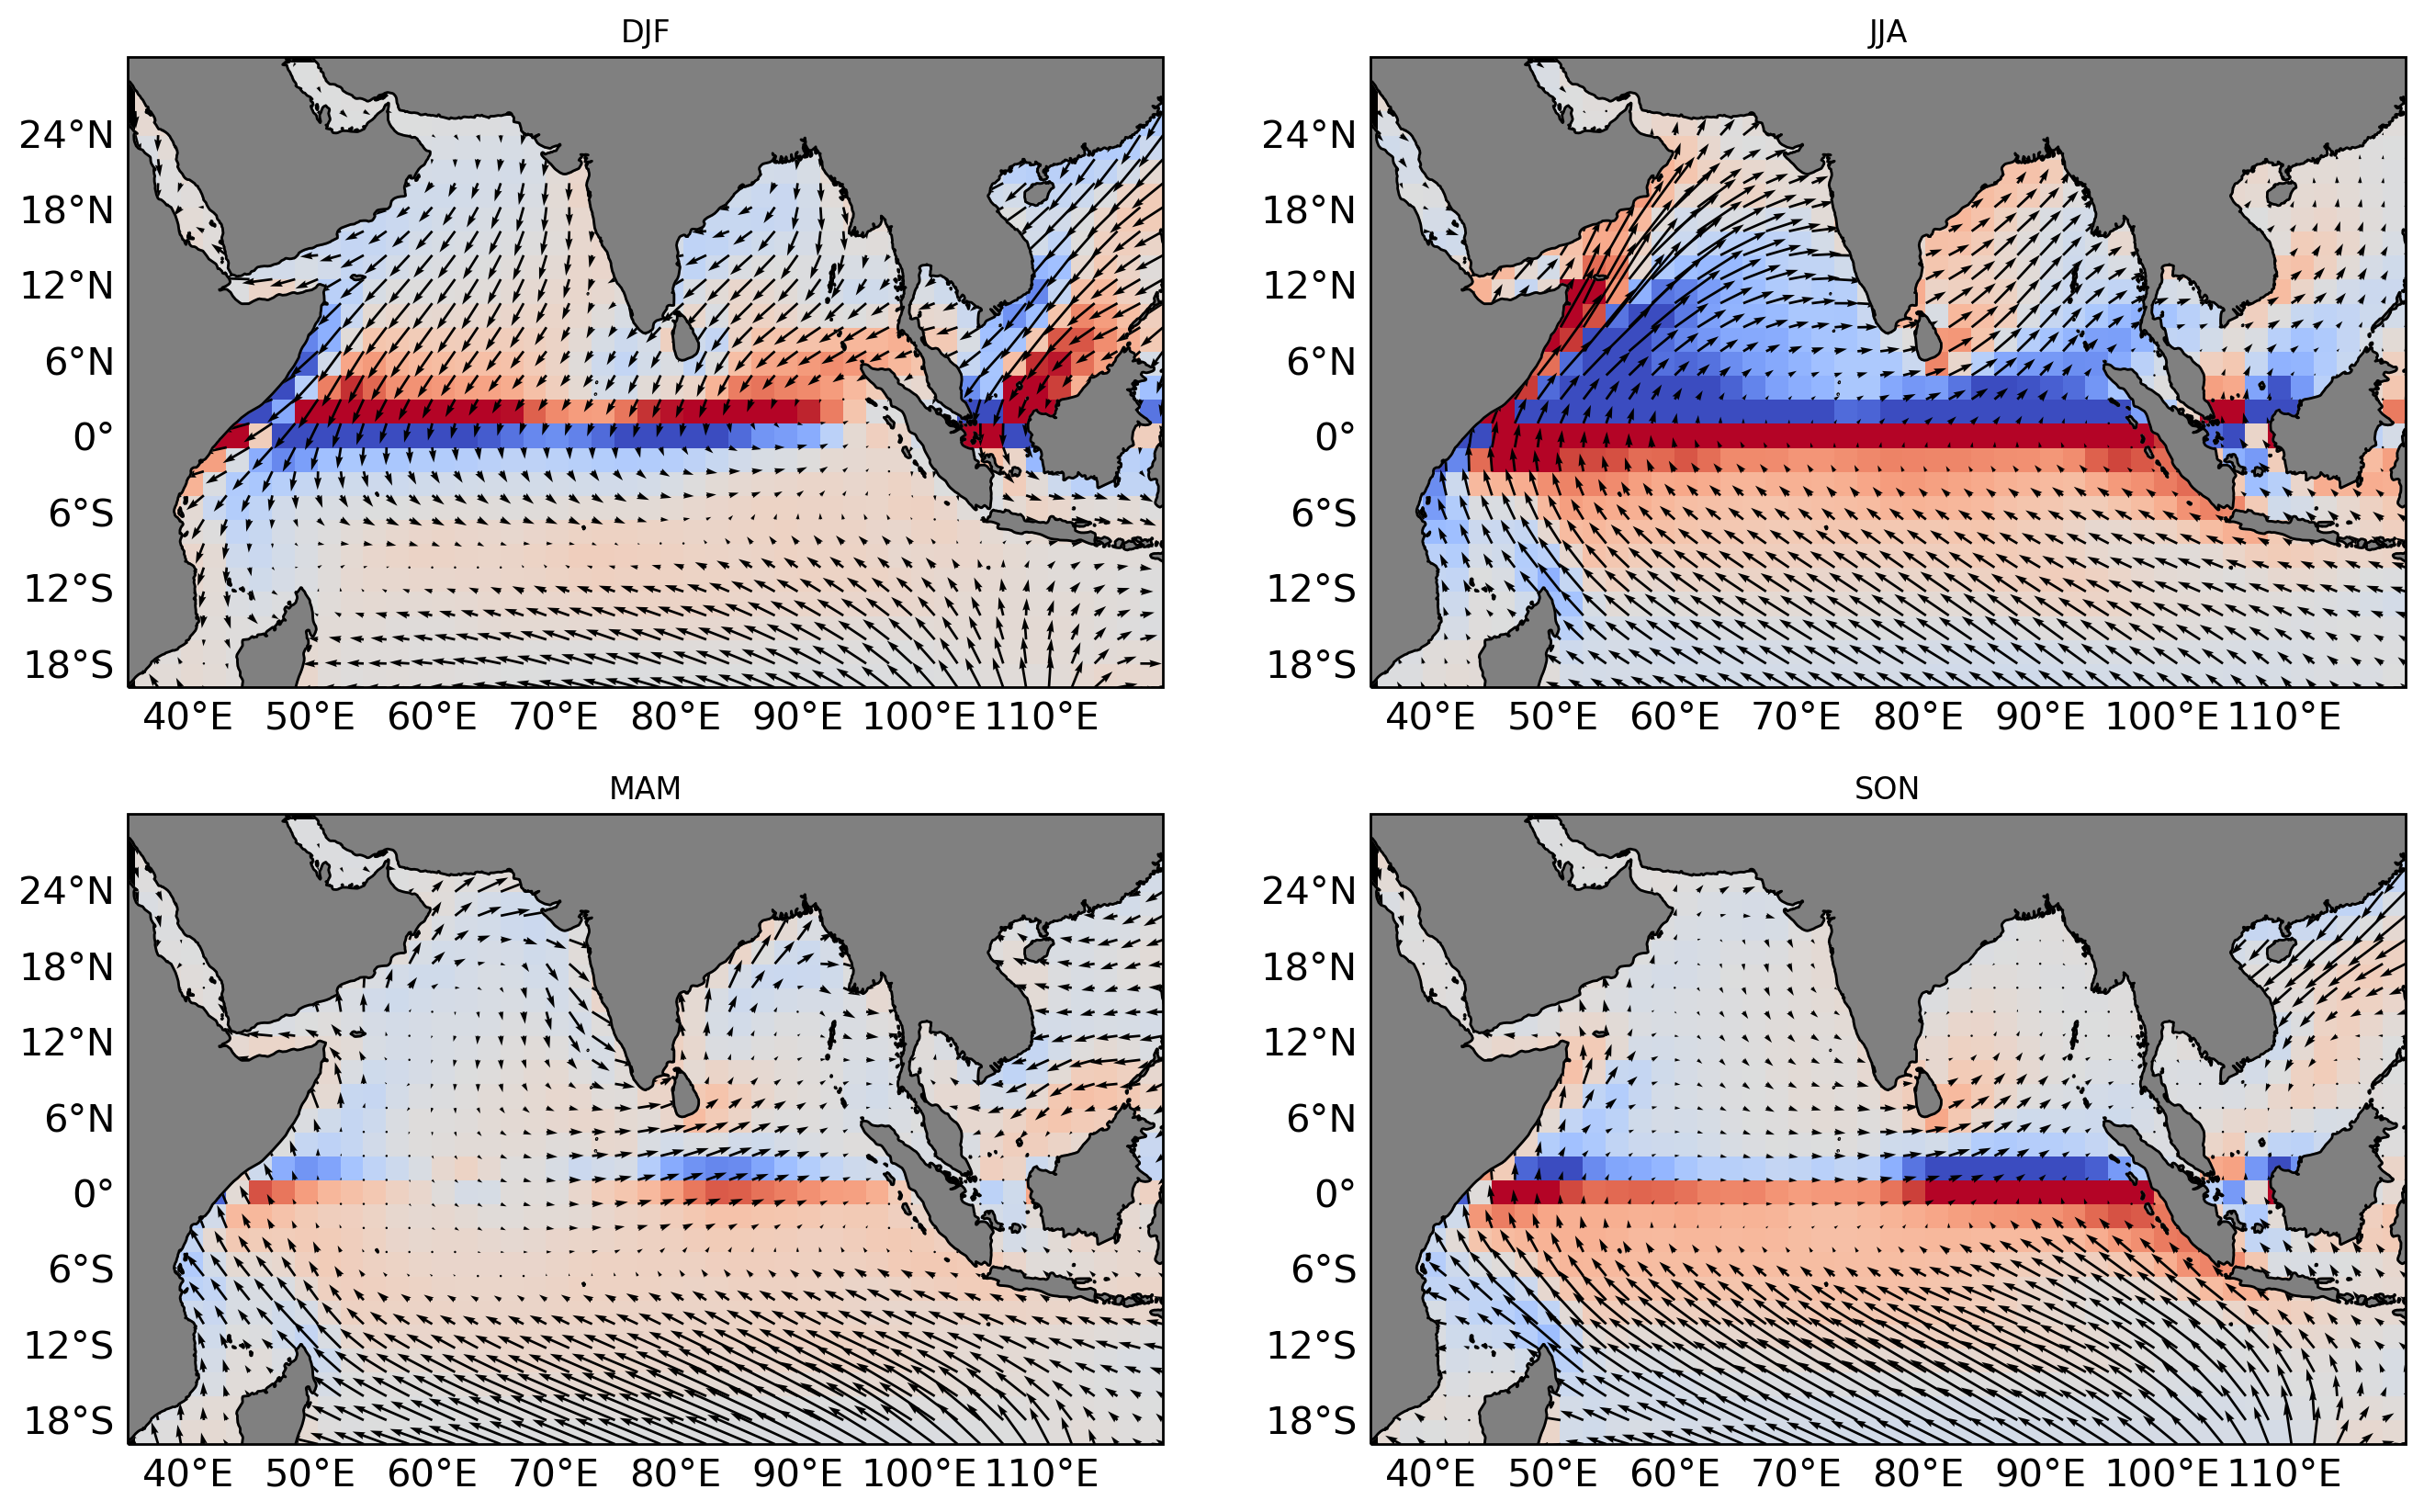

In [21]:
cmin = -2e-5
cmax = 2e-5
fig, axes = plt.subplots(nrows = 2, ncols = 2,figsize=(16,10),dpi=200,subplot_kw={'projection': ccrs.PlateCarree()})

ax = axes[0,0]
p = ax.pcolor(xx,yy,ds.W_Ek_seas_clim[0,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,ds.uwnd_seas_clim[0,:,:],ds.vwnd_seas_clim[0,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[0]))

ax = axes[0,1]
p = ax.pcolor(xx,yy,W_Ek_seas_clim[1,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[1,:,:],tau_y_seas_clim[1,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[1]))

ax = axes[1,0]
p = ax.pcolor(xx,yy,W_Ek_seas_clim[2,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[2,:,:],tau_y_seas_clim[2,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[2]))

ax = axes[1,1]
p = ax.pcolor(xx,yy,W_Ek_seas_clim[3,:,:],cmap = plt.cm.coolwarm, vmin = cmin, vmax = cmax)
ax.quiver(xx,yy,tau_x_seas_clim[3,:,:],tau_y_seas_clim[3,:,:])
add_land(ax,[35,120,-20,30])
ax.set_title(np.array(ds.season[3]))




In [ ]:
# group into summer/fall, winter/spring
# group into positive and negative iod years during 2 seasons


In [ ]:
def latlon_to_xyz(lat,lon):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """
    r = 6371 # https://en.wikipedia.org/wiki/Earth_radius
    theta = np.pi/2 - np.deg2rad(lat) 
    phi = np.deg2rad(lon)
    x = r * np.sin(theta) * np.cos(phi) # bronstein (3.381a)
    y = r * np.sin(theta) * np.sin(phi)
#     z = r * math.cos(theta)
    return [x,y]